# 1. Markov Decision Processes (MDP) $\langle S, A, R, P, P_0, H, \gamma\rangle$

$S$ a set of states.\
$A$ a set of actions.\
$R$ a reward mapping : $S \times A \rightarrow \mathbb{R}$.\
$P$ the transition probabibility distribution $S \times A \rightarrow \Delta S$.\
$P_0$ the initial distribution over states: $s_0 \in S \sim P_0$.\
$H$ the horizon: the number of transition per episode.\
$\gamma$ the discount factor in $(0,1)$.


MDPs are used to model sequential decision tasks in which at each time step $t$, an agent has to take an action given its current state. From $t=0$ to $t=H$, an agent observes state $s_t$ and takes action $a_t$. The agent then transitions to $s_{t+1}$ with probability $P(s_{t+1}|s_t, a_t)$ and receives reward $r_t = R(s_t,a_t,s_{t+1})$. At $t=0$, the agent "spawns" in an initial state $s_0$ with probability $P_0(s_0)$. One can also define terminal states that are such that an agent will not take actions in those states: in such terminal states the MDP stops even though $t<H$. An episode or a trajectory in a MDP, is a sequence of length at most $H$ of transition tuples ($s_t, a_t, r_t, s_{t+1}$).

With Dynamic Programmic or Reinforcement Learning, it is possible to train agents in MDPs in order to learn good solutions for sequential decision tasks. Such solutions are called policies and are mappings from actions to distributions over actions: $\Pi: S \rightarrow \Delta A$. The goal of Dynamic Programming and RL is to find the optimal policy $\pi^* = \underset{\pi \in \Pi}{\operatorname{argmax}} \underset{s_0 \sim P_0,a_t \sim \pi(s_t),s_{t+1}\sim P(s_t, a_t)}{\mathbb{E}}\left [ \underset{t=0}{\overset{H}{\sum}}\gamma^t R(s_t, a_t)\right ]$. The latter objective function finds policies that maximize the expected cumulative reward of the MDP: we want to find a policy that will, in expectation, generate MDP episodes with high rewards!

## 1.1 Exercise 1: Implement a Markov Decicion Process class.
In the exercises, we will consider that states and actions are finite: $|S| < \infty, |A| < \infty $. For such discrete MDPs, the optimal policy is deterministic i.e $\pi^*: S \rightarrow A$.



In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Mdp:
    """
    defines a Markov Decision Process
    """
    def __init__(
        self,
        states: list,
        actions: list,
        initial_distribution: np.array, #P0
        transition_probability: np.array, #P
        reward_function: np.array, #R
        gamma: float = 0.9,
        terminal_states: list = [],
        Horizon: int = 50,
    ):
        self.states = states
        self.nb_states = len(states)
        self.terminal_states = terminal_states

        self.actions = actions
        self.nb_actions = len(actions)

        self.P = transition_probability
        self.P0 = initial_distribution  # distribution used to draw the first state of the agent, ased in method reset()

        self.R = reward_function

        self.Horizon = Horizon  # maximum length of an episode
        self.gamma = gamma  # discount factor

        self.timestep = 0
        self.current_state = None

        assert self.check_P_is_distrib(), "the transition matrix is not a distribution over (S,A)"
        assert self.check_P0_is_distrib(), "initial state is not drawn according to a distribution"


    # TODO: write methods to check arrays are probability distributions
    def check_P_is_distrib(self):
        return np.all(np.logical_and(self.P >= 0, self.P <= 1)) and np.allclose(np.sum(self.P, axis=2), np.ones((self.nb_states, self.nb_actions)), rtol=1e-05, atol=1e-08)
    def check_P0_is_distrib(self):
        return np.all(np.logical_and(self.P >= 0, self.P <= 1)) and np.all(np.sum(self.P0, axis=0) == 1)

    def reset(self):  # Initializes an episode and returns the state of the agent.
        self.current_state = np.random.choice(a=self.states, p=self.P0)
        self.timestep = 0
        return self.current_state

    def done(self):  # returns True if an episode is over
        # TODO: An episode is over if the current state is a terminal state,
        # OR if the length of the episode is greater than the Horizon..
        return self.timestep >= self.Horizon or self.current_state in self.terminal_states

    def step(self, a):  # Given the current state, and an action, performs a transtion in the MDP,
        # TODO: Draw the next state according to the transition matrix.
        next_state = np.random.choice(a=self.states, p=self.P[self.current_state, a])
        # TODO: Get the reward of the transition.
        reward = self.R[self.current_state, a, next_state]

        self.timestep += 1
        self.current_state = next_state
        done = self.done()  # checks if the episode is over

        return next_state, reward, done

    def one_episode(self, policy):
        state = self.reset()
        done = False
        score = 0
        while not done:
            action = policy(state)
            next_state, r, done = self.step(action)
            score += r
            state = next_state
        return score


## 1.2 Exercise 2: Model the blackjack with dice game using your MDP class and evaluate the performances of simple policies.

In blackjack with a die, the goal is to throw as many die as one wants, sequentially, in order to obtain a sum of dice as close as possible to 21. Take your time to model the problem.
An episode, i.e a single blackjacke with a die game, looks like this: agent throws a die, check the result, decides to throw again or not, if it threw, checks the sum of dice and repeat, else, the game is over. The score of the agent is the final sum of the dice (or 0, if the sum is strictly greater than 21).
- What should the states be ?
- What does the probability tranisition matrix looks like ?
- Are there terminal transitions ?
- What is the reward at time $t$ if the agent score is the *final* sum of dice?

In [3]:
### BLACKJACK WITH DICE ###
S = np.arange(22+1) # s = 0 is the initial state before any die is thrown.
                    # s = 22 is a terminal state for dice sums > 21 and for deciding to stop.
A = [0, 1] # To throw, or not.

# The initial state of the MDP is always s = 0.
P0 = np.zeros(len(S))
P0[0] = 1

# The transition probabilities of having a dice sum of 18 know we throw a dice
# and we currently have a sum of 16 is the probability of getting a two in a die
# throw: P(snext=18|s=16,a=1) = 1/6.
# We strore P in a |S|x|A|x|S| matrix.
P = np.zeros((len(S), len(A), len(S)))
for s in S:
    # If s is 22, we never take actions because it is a terminal state. However to ensure that P[s, a, s'] is a distribution, we still normalize 
    if s==22:
        P[s,1,:] = 1/len(S)
    else:
        max_sum = s + 6
        if max_sum  > 21:
            risk = max_sum - 21
            P[s, 1, s+1: -1] = 1/6
            P[s, 1, -1] = risk/6
        else:
            P[s, 1, s+1: s + 1 + 6] = 1/6
    # When stoping to throw, the mdp transitions to the terminal state
    P[s, 0, -1] = 1

# Implement the reward function as |S|x|A| matrix
R = np.zeros((len(S), len(A), len(S)))
for s in S:
    R[s, 0, :] = s
    R[s, 1, :] = 0

blackjack_dice = Mdp(S, A, P0, P, R, terminal_states=[22])

A simple class for policies (a policy $\pi$ takes a state $s$ and returns an action $a$).

In [4]:
class Policy:
    def __init__(self, mdp:Mdp):
        self.mdp = mdp

    def get_action(self, state):
        raise NotImplementedError

class Uniform(Policy):
    def __init__(self, mdp:Mdp):
        super().__init__(mdp)

    def get_action(self, state):
        return np.random.randint(self.mdp.nb_actions)

Implement a simple policy that throw a die only if the score is below 16.

In [5]:
class ThresholdPolicy(Policy):
    def __init__(sefl, mdp):
        super().__init__(mdp)

    def get_action(self, state):
        # TODO
        return int(state < 16)

In [6]:
pol_unif = Uniform(blackjack_dice).get_action
# Let us check the average performance of the random policy on 100 blackjack with dice games.
policy_unif_eval = []
for episodes in range(100):
    policy_unif_eval.append(blackjack_dice.one_episode(pol_unif))

pol_thresh = ThresholdPolicy(blackjack_dice).get_action
# Let us check the average performance of the threshold policy on 100 blackjack with dice games.
policy_thresh_eval = []
for episodes in range(100):
    policy_thresh_eval.append(blackjack_dice.one_episode(pol_thresh))


print("mean +- std of the score of the uniform policy: {} +/- {}".format(np.mean(policy_unif_eval), np.std(policy_unif_eval)))
print("mean +- std of the score of the threshold policy: {} +/- {}".format(np.mean(policy_thresh_eval), np.std(policy_thresh_eval)))


mean +- std of the score of the uniform policy: 3.3 +/- 4.497777228809803
mean +- std of the score of the threshold policy: 17.62 +/- 1.4681961721786365


# 2. Dynamic Programming.
## 2.1 State value function $V^{\pi}(s)$
One way to find the optimal policy for a MDP is to find the states with highest value, then $\pi^*$ is the policy that visits those states. The value of a state, given a policy $\pi$, is the expected cumulative reward obtained by $\pi$ over MDP episodes when starting the episodes in $s_0 = s$. It is defined as follows with the Bellman expectation equation:\
$V^{\pi}(s) = \underset{s'\in S}{\sum} P(s'|s, \pi(s))(R(s, \pi(s), s') + \gamma V^{\pi}(s'))$\
The value of state $s$ is simply the reward obtained by $\pi$ in state $s$, plus the the value of the expected next state $s'$.
## 2.2 Exercise 3: Implement the Value Iteration algorithm
The Bellman optimality equation defines an algorithm to find the value function associated with the optimal policy. \
$V^*(s) = \underset{a}{\operatorname{max}}\left [ \underset{s'\in S}{\sum} P(s'|s, a)(R(s, a, s') + \gamma V^{*}(s'))\right]$

[The Value Iteration algorithm](http://incompleteideas.net/book/ebook/node44.html)

In [7]:
def VI(mdp, eps = 1e-2): #Value Iteration using the state value V

    V = np.zeros((mdp.nb_states)) #initial state values are set to 0
    list_error = []
    quitt = False

    while quitt==False:
        Vold = V.copy()
        for s in mdp.states:
            # TODO
            if s in mdp.terminal_states:
                continue
            else:
            # Compute the value of the state s for each action a of the MDP action space
                V_temp = [] 
                for a in mdp.actions : 
                    # Process sum of next states
                    sum = 0
                    for s_next in mdp.states:
                        sum = sum + mdp.P[s,a,s_next]*(mdp.R[s, a, s_next] + mdp.gamma * Vold[s_next])
                    V_temp.append(sum)         
                # Select the highest state value among those computed
                V[s] = np.max(V_temp)

        # Test if convergence has been reached
        error = np.linalg.norm(V-Vold)
        list_error.append(error)
        if error < eps :
            quitt = True

    return V, list_error


Run VI on the blackjack with dice MDP and plot the convergence of the algorithm for different thresholds $\epsilon$.

[10.42598277 10.74032638 11.06744805 11.40977287 11.74671306 12.09086333
 12.45162383 12.83581963 13.24821272 13.69192411 13.99297748 14.38519781
 14.85669375 15.397125   15.9975     16.65       16.         17.
 18.         19.         20.         21.          0.        ]


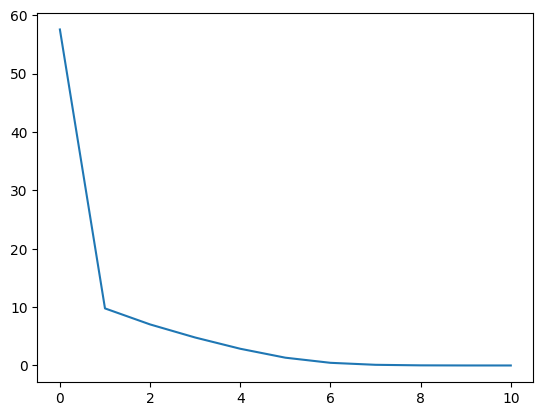

In [8]:
# TODO
V, list_error = VI(blackjack_dice, eps = 0.001)
print(V)
plt.plot(list_error)

You can visualiwe the optimal Value function:

([], [])

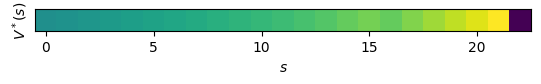

In [9]:
tmp = V.reshape(-1,1)
plt.imshow(tmp.T)
plt.xlabel("$s$")
plt.ylabel("$V^*(s)$")
plt.yticks([])

## 2.3 Exercise 4: Get the optimal policy $\pi^*$ from $V^*$.
Implement the class PolicyFromV. It takes as input an MDP and the associated $V^*$. In state $s$, $\pi^*(s)$ should return the action $a$ that leads to the next state $s'$ with highest value $V^*(s')$.\
$\pi^*(s) = \underset{a}{\operatorname{argmax}}\left [ \underset{s'\in S}{\sum} P(s'|s, a)(R(s, a, s') + \gamma V^{*}(s'))\right]$

In [10]:
class PolicyFromV(Policy):
    def __init__(self, mdp, V):
        super().__init__(mdp)
        self.V = V
        self.get_policy()

    def get_policy(self):
        self.policy = np.zeros(self.mdp.nb_states)
        for s in self.mdp.states:
            # TODO
            if s in self.mdp.terminal_states:
                continue
            else:
            # Compute the value of the state s for each action a of the MDP action space
                V_temp = [] 
                for a in self.mdp.actions : 
                    # Process sum of next states
                    sum = 0
                    for s_next in self.mdp.states:
                        sum = sum + self.mdp.P[s,a,s_next]*(self.mdp.R[s, a, s_next] + self.mdp.gamma * self.V[s_next])
                    V_temp.append(sum)         
                # Select the highest state value among those computed
                self.policy[s] = np.argmax(V_temp)

    def get_action(self, state):
        return int(self.policy[state])

Compare the performances of $\pi^*$ with $\pi^{\text{unif}}$ and $\pi^{\text{thresh}}$ on 100 blackjack with dice games.  

In [11]:
# TODO
pol_opt = PolicyFromV(blackjack_dice, V).get_action
# Let us check the average performance of the threshold policy on 100 blackjack with dice games.
policy_opt_eval = []
for episodes in range(100):
    policy_opt_eval.append(blackjack_dice.one_episode(pol_opt))


print("mean +- std of the score of the opt policy: {} +/- {}".format(np.mean(policy_opt_eval), np.std(policy_opt_eval)))

mean +- std of the score of the opt policy: 17.71 +/- 1.4303496076134672


Interpret your policy. Can you explain how your policy $\pi^*$ plays blackjack with dice ?

## 2.4 State-action values $Q^{\pi}(s,a)$
Similarly to $V^{\pi}(s)$ it is possible to define the state-aciton value of $s,a$ when following policy $\pi$. The state-action value $Q^{\pi}(s,a)$ is the expected cumulative reward obtained by $\pi$ over MDP episodes when starting the episodes in $s_0 = s$ and choosing $a_0 = a$. \
$Q^{\pi}(s,a) = \underset{s'\in S}{\sum} P(s'|s, a)(R(s, a, s') + \gamma V^{\pi}(s'))$\
We also have: \
$Q^*(s,a) = \underset{s'\in S}{\sum} P(s'|s, a)(R(s, a, s') + \gamma{\operatorname{max}}Q^*(s',a'))$

# 3. Reinforcement Learning.
By contrast with dynamic programming, a reinforcement learning agent is used when the MDP is unknown. More precisely, the state and action are known, but the agent does not know the transition nor the reward function.
## 3.1 Q-Learning
The Q-learning algorithm learns an estimate $\hat{Q}$ of $Q^*$. It does so without an MDP transition probability model: it is a model-free RL algorithms. Q-learning collects transitions $(s,a,r,s')$ following a behaviour policy $\pi^B$. For each collected transitions, $\hat{Q}$ is updated as follows:\
$\hat{Q}(s,a) \leftarrow \hat{Q}(s,a) + \alpha \delta$\
Where $\delta$ is the temporal difference error:\
$r + \gamma \underset{a'}{\operatorname{max}}\hat{Q}(s',a') - \hat{Q}(s,a)$\
The behaviour policy trades-off exploration and exploitation when collecting transitions in the MDP. For example, $\pi^B$ can be the epsilon-greedy policy:\
$\pi^\epsilon(s) = \pi^{\text{unif}}, \text{ if } \epsilon < 0.3$\
$\pi^\epsilon(s) = \underset{a}{\operatorname{argmax}}\hat{Q}(s, a), \text{ else }$
## 3.2 Exercise 5: Implement the Q-Learning algorithm
[Q-Learning algorithm](http://incompleteideas.net/book/ebook/node65.html)

In [12]:
def QLearning(mdp, behaviour_pol, alpha=0.1, nb_iter=int(1e4)):
    Qhat = np.zeros((mdp.nb_states, mdp.nb_actions))
    list_Qs = []
    s = mdp.reset()
    for _ in range(nb_iter):
        a = behaviour_pol(s, Qhat)
        s_next, r, done = mdp.step(a)

        if done:
            Qhat[s, a] = r
            s = mdp.reset()
        else:
            delta = r + mdp.gamma * np.max(Qhat[s_next,:]) - Qhat[s,a] # TODO
            Qhat[s, a] = Qhat[s,a] + alpha * delta # TODO
            list_Qs.append(Qhat.copy())
            s = s_next

    return Qhat, list_Qs

class EpsGreedyPolicy(Policy):
    def __init__(self, mdp, epsilon):
        self.mdp = mdp
        self.eps = epsilon

    def get_action(self, state, Q):
        if np.random.random() < self.eps:
            return np.random.randint(self.mdp.nb_actions)
        else:
            return np.argmax(Q[state, :])

Try Q-Learning to learn an estimate of the optimal state-action value function of the blackjack with dice MDP.
- Visualize $\hat{Q}$ returned by Q-Learning (use $\texttt{plt.imshow()}$). Does this Q function makes sense ?
- Make a plot to compare the convergence of $\hat{Q}$ over iterations for different values of $\epsilon$ and different learning rates $\alpha$.
- Compare the performance of the greedy policy $\pi^{\text{greedy}}(s) = \underset{a}{\operatorname{argmax}}\hat{Q}(s, a)$ with other policies (uniform, threshold, $\pi^*$) on 100 episodes.

In [13]:
pol_behaviour = EpsGreedyPolicy(blackjack_dice, epsilon=0.3).get_action
q, list_Qs= QLearning(blackjack_dice, pol_behaviour)
# TODO

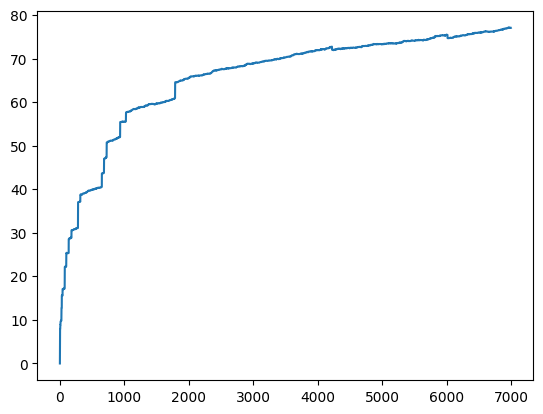

In [14]:
plt.plot([np.linalg.norm(q_i) for q_i in list_Qs])

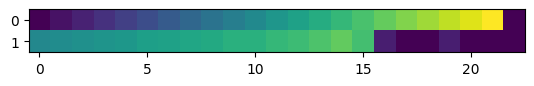

In [15]:
plt.imshow(q.T)


# 4. Homework: Maze MDPs and Reinforcement Learning.
This homework is open to interpretation and implementation. You can work in pairs.

## Deadline 17/01/2024 23:59 email to hector.kohler@inria.fr

- Exercise 1: implement a Maze MDP generator. Mazes are often use to benchmark new RL algorithms. One can think of a maze MDP as rectangle divided in cells. Each cells is a MDP state. The upper left cell is the initial state and the bottom right is the exit. Walls should be placed at random in the MDP: this will be done by specifying a fraction of cell states that are non-accessible. There are 4 actions in a maze MDP: left, right, up, dowm. All state-action pairs give a 0 reward, except a state-pair that leads to the exit (terminal) state in the bottom right cell.
    - How to make sure that a generated maze can be exited ? You can try checking $V^*(s_{start}) > 0$.
    - Your Maze MDP generator should take as arguments: a width, a height, and a fraction of cell walls. |S| = witdh x height.
- Exercise 2: in a 3-pages report, present the performances of Q-Learning on maze MDPs.
    - Compare eps-greedy policy and softmax behaviour policy.
    - Compare different values of the exploration parameters (epsilon for eps-greedy and tau for softmax).
    - Compare different learning rates.
    - Compare different sizes and difficluties of Maze MDPs.
    - Check that your learned Q functions make sense.
- In general, describe your experiments and do not put too much figures (choose a few convincing figures) and then describe what you observe and try to understand if it makes sense.